# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

0.4.1


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

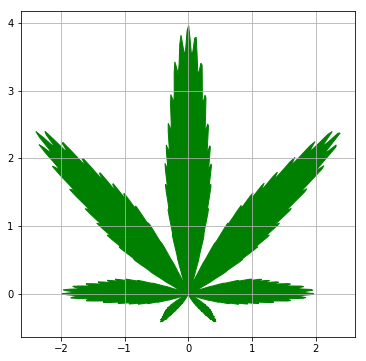

In [3]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = ((1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) *
       (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta)))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [4]:
from scipy.signal import convolve2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = convolve2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [50]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    filters = torch.tensor([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=torch.float).view(1, 1, 3, 3)
    N = torch.nn.functional.conv2d(Z.view(1, 1, Z.size()[0], Z.size()[1]), filters, padding=1).view(Z.size())
    
    # Apply rules
    birth = torch.eq(N, 3) & torch.eq(Z, 0)
    survive = (torch.eq(N, 2) | torch.eq(N, 3)) & torch.eq(Z, 1)
    Z = (birth | survive).type(torch.FloatTensor)
    return Z

In [51]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


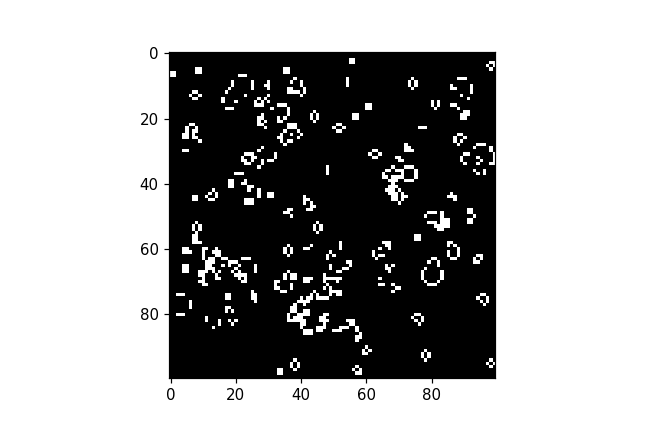

In [53]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


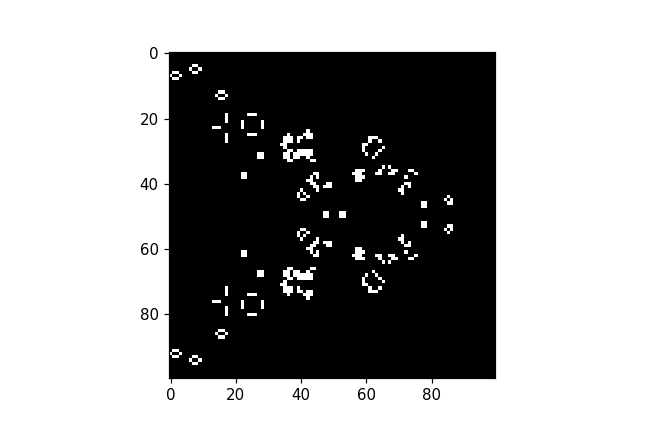

In [57]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [58]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [ ]:
X_train.shape, X_test.shape

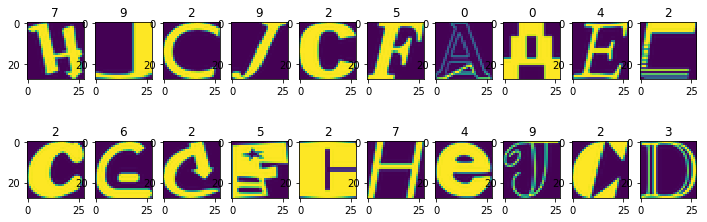

In [59]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

### Superlazy approach

In [60]:
T = len(set(y_train))

In [132]:
# create network again just in case
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 512))
model.add_module('non_lin', nn.Sigmoid())
model.add_module('second', nn.Linear(512, T))
model.add_module('softmax', nn.LogSoftmax())

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [133]:
from sklearn.metrics import accuracy_score
def evaluate(model, x, y):
    y_pred = model(torch.tensor(x, dtype=torch.float32))
    y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
    return accuracy_score(y, y_pred)

In [135]:
num_epochs = 4000
batch_size = 256
history = []
accuracies = []

for i in range(num_epochs):
    ix = np.random.randint(0, len(X_train), batch_size)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.long)

    y_predicted = model(x_batch)
    loss = F.nll_loss(y_predicted, y_batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if i % 10 == 0:
        accuracies.append([evaluate(model, X_train[ix], y_train[ix]), evaluate(model, X_test, y_test)])
        print("step #%i | mean loss = %.3f | batch_accuracy = %.3f | test_accuracy = %.3f" % 
              (i, np.mean(history[-10:]), accuracies[-1][0], accuracies[-1][1]))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


step #0 | mean loss = 0.233 | batch_accuracy = 0.953 | test_accuracy = 0.897
step #10 | mean loss = 0.276 | batch_accuracy = 0.961 | test_accuracy = 0.897
step #20 | mean loss = 0.297 | batch_accuracy = 0.910 | test_accuracy = 0.897
step #30 | mean loss = 0.296 | batch_accuracy = 0.918 | test_accuracy = 0.897
step #40 | mean loss = 0.280 | batch_accuracy = 0.906 | test_accuracy = 0.897
step #50 | mean loss = 0.274 | batch_accuracy = 0.914 | test_accuracy = 0.898
step #60 | mean loss = 0.289 | batch_accuracy = 0.926 | test_accuracy = 0.898
step #70 | mean loss = 0.255 | batch_accuracy = 0.918 | test_accuracy = 0.898
step #80 | mean loss = 0.277 | batch_accuracy = 0.930 | test_accuracy = 0.899
step #90 | mean loss = 0.284 | batch_accuracy = 0.934 | test_accuracy = 0.899
step #100 | mean loss = 0.287 | batch_accuracy = 0.895 | test_accuracy = 0.899
step #110 | mean loss = 0.308 | batch_accuracy = 0.930 | test_accuracy = 0.898
step #120 | mean loss = 0.285 | batch_accuracy = 0.922 | test_a

step #1040 | mean loss = 0.242 | batch_accuracy = 0.902 | test_accuracy = 0.901
step #1050 | mean loss = 0.263 | batch_accuracy = 0.938 | test_accuracy = 0.901
step #1060 | mean loss = 0.265 | batch_accuracy = 0.938 | test_accuracy = 0.902
step #1070 | mean loss = 0.258 | batch_accuracy = 0.945 | test_accuracy = 0.902
step #1080 | mean loss = 0.247 | batch_accuracy = 0.934 | test_accuracy = 0.900
step #1090 | mean loss = 0.200 | batch_accuracy = 0.949 | test_accuracy = 0.900
step #1100 | mean loss = 0.231 | batch_accuracy = 0.949 | test_accuracy = 0.900
step #1110 | mean loss = 0.255 | batch_accuracy = 0.914 | test_accuracy = 0.902
step #1120 | mean loss = 0.247 | batch_accuracy = 0.922 | test_accuracy = 0.901
step #1130 | mean loss = 0.237 | batch_accuracy = 0.918 | test_accuracy = 0.901
step #1140 | mean loss = 0.239 | batch_accuracy = 0.926 | test_accuracy = 0.900
step #1150 | mean loss = 0.219 | batch_accuracy = 0.938 | test_accuracy = 0.900
step #1160 | mean loss = 0.216 | batch_a

step #2080 | mean loss = 0.197 | batch_accuracy = 0.957 | test_accuracy = 0.902
step #2090 | mean loss = 0.194 | batch_accuracy = 0.973 | test_accuracy = 0.901
step #2100 | mean loss = 0.215 | batch_accuracy = 0.938 | test_accuracy = 0.901
step #2110 | mean loss = 0.188 | batch_accuracy = 0.949 | test_accuracy = 0.901
step #2120 | mean loss = 0.203 | batch_accuracy = 0.945 | test_accuracy = 0.902
step #2130 | mean loss = 0.190 | batch_accuracy = 0.934 | test_accuracy = 0.901
step #2140 | mean loss = 0.187 | batch_accuracy = 0.941 | test_accuracy = 0.903
step #2150 | mean loss = 0.193 | batch_accuracy = 0.945 | test_accuracy = 0.901
step #2160 | mean loss = 0.191 | batch_accuracy = 0.961 | test_accuracy = 0.902
step #2170 | mean loss = 0.214 | batch_accuracy = 0.949 | test_accuracy = 0.902
step #2180 | mean loss = 0.187 | batch_accuracy = 0.949 | test_accuracy = 0.902
step #2190 | mean loss = 0.197 | batch_accuracy = 0.949 | test_accuracy = 0.903
step #2200 | mean loss = 0.188 | batch_a

step #3120 | mean loss = 0.175 | batch_accuracy = 0.969 | test_accuracy = 0.904
step #3130 | mean loss = 0.165 | batch_accuracy = 0.969 | test_accuracy = 0.903
step #3140 | mean loss = 0.174 | batch_accuracy = 0.957 | test_accuracy = 0.903
step #3150 | mean loss = 0.197 | batch_accuracy = 0.969 | test_accuracy = 0.905
step #3160 | mean loss = 0.173 | batch_accuracy = 0.961 | test_accuracy = 0.904
step #3170 | mean loss = 0.158 | batch_accuracy = 0.961 | test_accuracy = 0.903
step #3180 | mean loss = 0.166 | batch_accuracy = 0.953 | test_accuracy = 0.903
step #3190 | mean loss = 0.140 | batch_accuracy = 0.980 | test_accuracy = 0.903
step #3200 | mean loss = 0.149 | batch_accuracy = 0.965 | test_accuracy = 0.903
step #3210 | mean loss = 0.166 | batch_accuracy = 0.957 | test_accuracy = 0.903
step #3220 | mean loss = 0.152 | batch_accuracy = 0.984 | test_accuracy = 0.903
step #3230 | mean loss = 0.152 | batch_accuracy = 0.969 | test_accuracy = 0.903
step #3240 | mean loss = 0.130 | batch_a

In [106]:
num_epochs = 1000
batch_size = 256
history = []
accuracies = []

for i in range(num_epochs):
    ix = np.random.randint(0, len(X_train), batch_size)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.long)

    y_predicted = model(x_batch)
    loss = F.nll_loss(y_predicted, y_batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if i % 10 == 0:
        accuracies.append([evaluate(model, X_train[ix], y_train[ix]), evaluate(model, X_test, y_test)])
        print("step #%i | mean loss = %.3f | batch_accuracy = %.3f | test_accuracy = %.3f" % 
              (i, np.mean(history[-10:]), accuracies[-1][0], accuracies[-1][1]))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


step #0 | mean loss = 2.352 | batch_accuracy = 0.414 | test_accuracy = 0.303
step #10 | mean loss = 1.487 | batch_accuracy = 0.820 | test_accuracy = 0.809
step #20 | mean loss = 0.848 | batch_accuracy = 0.852 | test_accuracy = 0.849
step #30 | mean loss = 0.570 | batch_accuracy = 0.906 | test_accuracy = 0.859
step #40 | mean loss = 0.515 | batch_accuracy = 0.891 | test_accuracy = 0.869
step #50 | mean loss = 0.480 | batch_accuracy = 0.867 | test_accuracy = 0.875
step #60 | mean loss = 0.465 | batch_accuracy = 0.871 | test_accuracy = 0.873
step #70 | mean loss = 0.413 | batch_accuracy = 0.910 | test_accuracy = 0.880
step #80 | mean loss = 0.366 | batch_accuracy = 0.918 | test_accuracy = 0.879
step #90 | mean loss = 0.402 | batch_accuracy = 0.910 | test_accuracy = 0.885
step #100 | mean loss = 0.351 | batch_accuracy = 0.934 | test_accuracy = 0.885
step #110 | mean loss = 0.339 | batch_accuracy = 0.922 | test_accuracy = 0.886
step #120 | mean loss = 0.340 | batch_accuracy = 0.891 | test_a

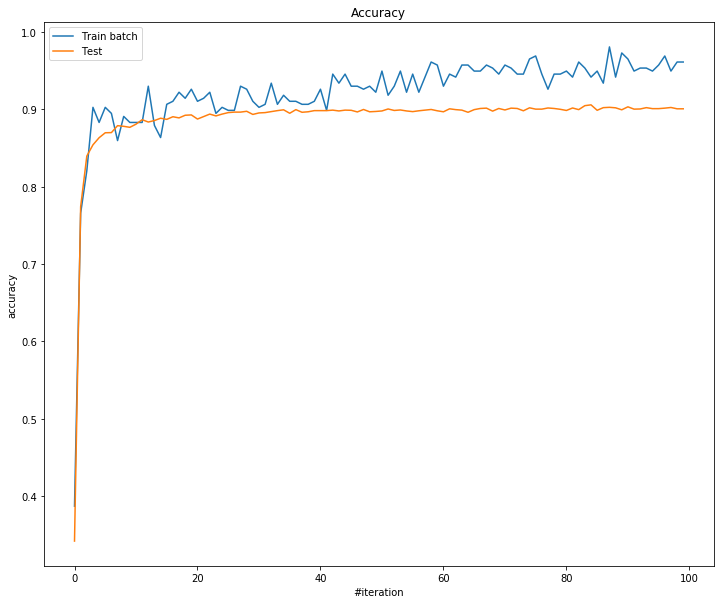

Current test_accuracy: 0.900449


In [111]:
plt.figure(figsize=(12, 10))

plt.title("Accuracy")
plt.xlabel("#iteration")
plt.ylabel("accuracy")
plt.plot([x[0] for x in accuracies], label="Train batch")
plt.plot([x[1] for x in accuracies], label="Test")
plt.legend()
plt.show()

print('Current test_accuracy: %f' % accuracies[-1][1])  

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

